# Beam Tracking Notebook

This notebook is an example of how to track the beam center as the rotation stage moves through a range of angles, which we can then recover the index of refraction from. For the actual index of refraction calculation, see the complementary `CurveFitting` or `AdvancedCurveFitting` notebooks.

If you run into any errors, I highly recommend running the initialization script in this directory using:
```
> python Initialization.py
```

### Experimental Procedure

1. Place your sample in the vice on top of the rotational stage
2. Adjust the linear stage such that the sample is approximately lined up with the blue marker line
    - It is a good idea to rotate the stage to $\pm 50 ^{\circ}$ or so, and make sure the beam passes through an acceptable part of the sample
3. Turn on the Lauda and fan, and allow the container to come to the desired temperature
    - Note that the container will not actually come to the temperature that the Lauda is set to; you will likely need to set it lower than the temperature you actually want
4. Reset the rotational stage to the home position
5. Run the measurement procedure

In [1]:
from ESP301Control import RotationStage
from TLBP2Control import TLBP2

import numpy as np
import matplotlib.pyplot as plt

from tinkerforge.ip_connection import IPConnection
from tinkerforge.bricklet_humidity import BrickletHumidity
from tinkerforge.bricklet_temperature import BrickletTemperature

from IPython.display import clear_output

from time import sleep

from Settings import *

If you want to check whether all of the components are working (before actually connecting everything), you can run this cell -- though it is not actually necessary for the proper measurement.

In [3]:
from Initialization import fastInitialization
fastInitialization()

Rotation stage....................Working
Beam profiler.....................Working
Tinkerforge brick.................Error
Initialization complete!


False

The following cell will connect all of the devices that are needed to make the measurement, including the rotation stage, beam profiler, and temperature and humidity sensors.

In [7]:
# Make sure there isn't another process running on this server/port combination
HOST = 'localhost'
PORT = 4223

# These are found by using the BrickViewer program
HUMIDITY_UID = 'keg'
TEMP_UID = '6Jf'

# These constants are imported from the Settings.py file;
# see there for more information
stage = RotationStage(MOTION_CONTROLLER_PORT, ROTATION_STAGE_AXIS_NUM)
bp2Device = TLBP2()
ipcon = IPConnection()

humiditySensor = BrickletHumidity(HUMIDITY_UID, ipcon)
temperatureSensor = BrickletTemperature(TEMP_UID, ipcon)

ipcon.connect(HOST, PORT)
stage.connect()
# This can take up to 15 seconds, since it has to spin up the drum inside the
# beam profiler
bp2Device.connect() # Status code should be 0

0

Reset the rotation stage to a set position stored in non-volatile memory (ie. persistent after it is turned off). Note that it does not return exactly to the same point, but probably within $.005$ degrees each time. This error can build up though, so it may be necessary to manually align the stage via back-reflex of the laser every now and again.

Note that it isn't actually super important to have the stage perfectly centered, since we fit an arbitrary phase difference later on, which can account for any initial offset. Of course, if there is a huge offset ($\gt 15^{\circ}$) the data will not be symmetric, and this may affect the curve fitting.

In [8]:
# Reset the rotation stage to a set position
stage.resetToHome()
#stage.moveAbsolute(50)

0

Below are the possible values that can be saved with each measurement. If you would like more/different quantities that the beam profiler offers, you will have to edit the source code for the C# server; see `TLBP2Control/README.md` for more info.

Quantities with 2 values are of format: `(x, y)`

Gaussian fit parameters are of format: `(center, width, amplitude, fit percentage)`

In [5]:
bp2Device.getMeasurement()

{'centroid': array([  -56.493958, -1054.1558  ]),
 'peak': array([ -113.42316, -1103.1638 ]),
 'peak_intensity': array([40.702847, 50.91437 ]),
 'drum_speed': 10.274588374303255,
 'beam_width': array([1434.4841 , 1005.48267]),
 'gaussian_fit_params_x': array([4.4604360e+03, 1.4209744e+03, 9.1887980e+03, 9.3540430e-01]),
 'gaussian_fit_params_y': array([3.3435793e+03, 9.8075710e+02, 1.2195989e+04, 9.5180040e-01])}

Below is the actual procedure to take data, which involves rotating the stage by a small amount, measuring the beam profiler output, and repeating.

I would recommend using the gaussian center to fit later on, since this is the least volatile of the various measures of centrality, but the others are there if you would like to experiment with them.

Unfortunately, there is some bug with the motion controller where it will crash every now and again, which completely restarts the machine. If this happens during an experiment, there really isn't anything you can do about it, since it could crash in the middle of a movement step. This would give a maximum error of `dtheta` for all subsequent angles, which could be quite an issue. If it does happen to crash, it is best to simply restart the experiment... ¯\\\_(ツ)\_/¯

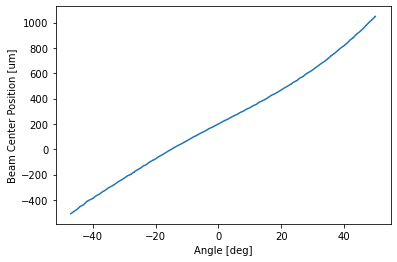

In [ ]:
# Move to the starting position, and set what our final angle should be
stage.moveAbsolute(50)
desiredAngle = -50

# What step size we use when changing the angle
dtheta = -1
# How many measurements we average over at each angle
averagingMeasurements = 20

# We probably don't actually need all of these values, but
# I will leave them in as an example. Usually the beam gaussian
# center is what I fit the curve too, since it is the least volatile.
peakPositionArr = []
centroidPosArr = []
gausCenterArr = []

peakPositionSTDArr = []
centroidPosSTDArr = []
gausCenterSTDArr = []

temperatureArr = []
humidityArr = []

angleArr = []

while stage.getAngle() > desiredAngle:
    peakIndividualMeasurements = np.zeros(averagingMeasurements)
    centroidIndividualMeasurements = np.zeros(averagingMeasurements)
    gausIndividualMeasurements = np.zeros(averagingMeasurements)
    
    for i in range(averagingMeasurements):
        measure = None
        # Sometimes we can get an error for the measurement
        # (eg. if the drum speed isn't high enough) so we
        # may have to measure multiple times to get a good one.
        while measure == None:
            measure = bp2Device.getMeasurement()
            
        peakIndividualMeasurements[i] = measure["peak"][0]
        centroidIndividualMeasurements[i] = measure["centroid"][0]
        gausIndividualMeasurements[i] = measure["gaussian_fit_params_x"][0]
        
    peakPositionArr.append(np.mean(peakIndividualMeasurements))
    peakPositionSTDArr.append(np.std(peakIndividualMeasurements))
    
    centroidPosArr.append(np.mean(centroidIndividualMeasurements))
    centroidPosSTDArr.append(np.std(centroidIndividualMeasurements))
    
    gausCenterArr.append(np.mean(gausIndividualMeasurements))
    gausCenterSTDArr.append(np.std(gausIndividualMeasurements))
    
    # The tinkerforge bricks use some weird units, so we have to
    # divide by these constants
    temperatureArr.append(temperatureSensor.get_temperature()/100)
    humidityArr.append(humiditySensor.get_humidity()/10)
    
    # Note that this will get the *actual* angle of the stage,
    # as opposed to the theoretical angle, so we shouldn't worry
    # about inaccuracies of the movement.
    angleArr.append(stage.getAngle())

    # Below here is just for plotting
    clear_output(wait=True)
    plt.errorbar(angleArr, centroidPosArr, yerr=centroidPosSTDArr)
    plt.xlabel("Angle [deg]")
    plt.ylabel("Beam Center Position [um]")
    plt.show()

    # As mentioned above, there can be some issues with the motion controller
    # crashing, but there isn't much we can do about it, since it would
    # introduce a significant error into the angle measurements.
    try:
        stage.moveRelative(dtheta)
    except:
        # If it crashes, we have to restart
        clear_output(wait=True)
        print('Motion controller crashed...')
        print('Please restart the experiment')
        break

This will save the data into a file, so it can be analyzed in the `CurveFitting` notebook.

It isn't a bad idea to include the wavelength of the laser in the name, since this information isn't included anywhere else.

In [5]:
with open('data/ruby_flat_700nm_2.txt', 'w') as outFile:
    outFile.write('angle,peak_position,peak_std,gauss_center,gauss_std,centroid,centroid_std,temp,humid')
    for i in range(len(angleArr)):
        outFile.write(f'\n{angleArr[i]},{peakPositionArr[i]},{peakPositionSTDArr[i]},{gausCenterArr[i]},{gausCenterSTDArr[i]},{centroidPosArr[i]},{centroidPosSTDArr[i]},{temperatureArr[i]},{humidityArr[i]}')

Especially if you are going to using the instruments in another script/program, you should disconnect them properly.

In [6]:
stage.disconnect()
bp2Device.disconnect()
ipcon.disconnect()